In [1]:
import sys
import re
import os
import numpy as np
import pandas as pd
import pysam
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
import gget
import mappy as mp

In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/scpc_test/restriction_sites/b01.sites.pq"

df = pd.read_parquet(fpath)
print(f"{df.shape=}")
print(f"{df['read_name'].nunique()=}")
df.head()

df.shape=(509531, 7)
df['read_name'].nunique()=457464


,read_name,n_sites,fragment_idx,read_start,read_end,length,seq
0,d2e216fe-c419-430d-9db0-fe09922fdc83,0,0,0,532,532,GTGTTATGTTACGTGCTTCGTTCAGTTACGTATTGCTGGTGCTGAA...
1,69df1420-7e2b-43b4-b44d-a2fc93f85617,0,0,0,518,518,GTTTTTGTATTCTACTCGTTCAGTTACGTATTGCTGGTGCTGAAGA...
2,fe7ece18-4bef-42ae-b7ef-e1f4ceeceba0,1,0,0,13,13,ATGTTTTGCATGT
3,fe7ece18-4bef-42ae-b7ef-e1f4ceeceba0,1,1,13,577,564,ATTCGTTCAGTTACGTGTATGCTGGTGCTAGTGTTTTTGCGTGGGA...
4,4fbae019-2d11-48a5-9747-c06a9c890ee4,0,0,0,492,492,TTGCATCTACTGGTTCAGTTACGTGTATTGCTTGTCTTTGTGTTAA...


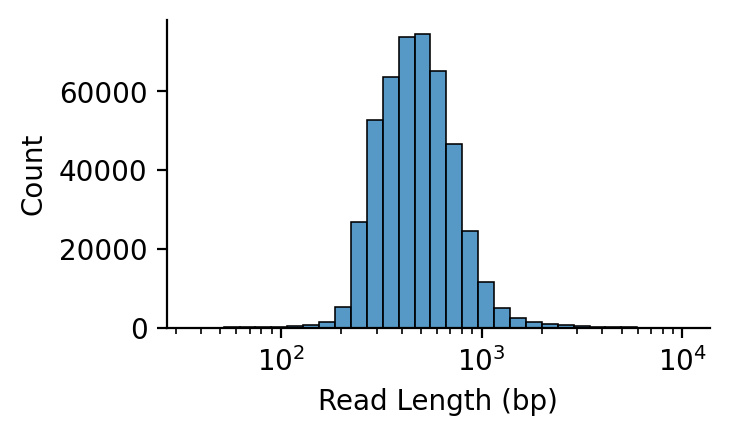

In [12]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 2

gx = df.groupby('read_name')['length'].sum().reset_index()

sns.histplot(data=gx, 
             x='length',
             log_scale=True,
             bins=31)

plt.xlabel("Read Length (bp)")
sns.despine()


0.114
0.000
n_sites
0    0.907379
1    0.082879
2    0.006868
3    0.001124
4    0.000433
Name: proportion, dtype: float64


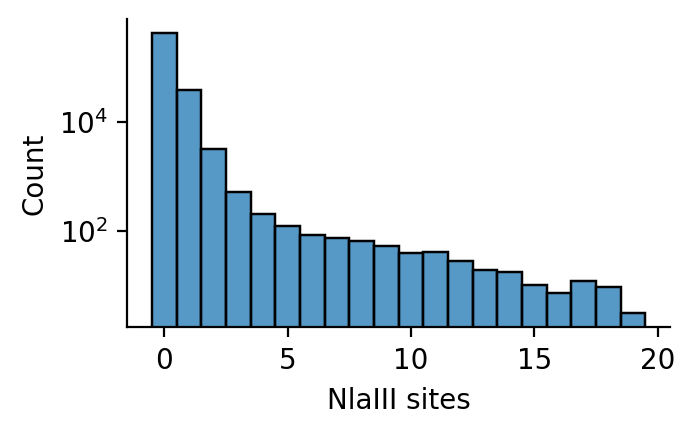

In [28]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 2

gx = df.groupby('read_name')['n_sites'].max().reset_index()
mask = (gx['n_sites'] < 20)

print(f"{gx['n_sites'].mean():.3f}")
print(f"{gx['n_sites'].median():.3f}")
print(gx['n_sites'].value_counts(normalize=True).head())

sns.histplot(data=gx[mask], 
             x='n_sites',
             discrete=True)

plt.yscale('log')
plt.xlabel("NlaIII sites")
sns.despine()

In [35]:
dpath = "/scratch/indikar_root/indikar1/cstansbu/scpc_test/reports/coverage_by_reference/"

res = []
for f in os.listdir(dpath):
    ref = f.split(".")[0]
    df = pd.read_csv(f"{dpath}{f}", sep='\t', nrows=20)
    df['ref'] = ref
    res.append(df)


res = pd.concat(res)
res.head()

,#rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,ref
0,1,1,195154279,487,51139,0.026204,0.000616,19.5,48.5,GRCm39
1,2,1,181755017,927,62559,0.034419,0.001205,22.4,35.3,GRCm39
2,3,1,159745316,393,35939,0.022498,0.000500,19.6,48.1,GRCm39
3,4,1,156860686,368,36076,0.022999,0.000551,19.6,46.6,GRCm39
4,5,1,151758149,490,48442,0.031920,0.000709,19.3,48.6,GRCm39


In [41]:
gx = res.groupby('ref').agg(
    mean_reads = ('numreads', 'mean'),
    mean_cov = ('coverage', 'mean'),
    mean_base = ('meanbaseq', 'mean'),
    mean_mapq = ('meanmapq', 'mean'),
).reset_index(drop=False)

print(gx)

           ref  mean_reads  mean_cov  mean_base  mean_mapq
0  129S1_SvImJ      407.60  0.032245     19.415     47.530
1     CAST_EiJ      409.55  0.032934     19.485     47.275
2       GRCm39      434.60  0.034648     19.510     46.180


In [42]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/barcode01_scPCR25o_3/reports/samtools_coverage/NlaIII_b01_GRCm39.txt"
res = pd.read_csv(fpath, sep='\t', nrows=20)
res['ref'] = 'old_pipe'
gx = res.groupby('ref').agg(
    mean_reads = ('numreads', 'mean'),
    mean_cov = ('coverage', 'mean'),
    mean_base = ('meanbaseq', 'mean'),
    mean_mapq = ('meanmapq', 'mean'),
).reset_index(drop=False)

print(gx)

        ref  mean_reads  mean_cov  mean_base  mean_mapq
0  old_pipe      260.85  0.032733      19.31      44.55


In [44]:
dpath = "/scratch/indikar_root/indikar1/cstansbu/scpc_test/reports/duplicates/"

res = []
for f in os.listdir(dpath):
    ref = f.split(".")[1]
    df = pd.read_csv(f"{dpath}{f}", sep='\t', comment="#")
    df['ref'] = ref
    res.append(df)

res = pd.concat(res)
res.head()

,LIBRARY,UNPAIRED_READS_EXAMINED,READ_PAIRS_EXAMINED,SECONDARY_OR_SUPPLEMENTARY_RDS,UNMAPPED_READS,UNPAIRED_READ_DUPLICATES,READ_PAIR_DUPLICATES,READ_PAIR_OPTICAL_DUPLICATES,PERCENT_DUPLICATION,ESTIMATED_LIBRARY_SIZE,ref
0,Unknown Library,5993,0,7439,588280,1084,0,0,0.180878,NaN,GRCm39
0,Unknown Library,5923,0,6735,588350,1099,0,0,0.185548,NaN,CAST_EiJ
0,Unknown Library,5943,0,7316,588330,1086,0,0,0.182736,NaN,129S1_SvImJ


In [48]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/barcode01_scPCR25o_3/align_table/NlaIII_b01_GRCm39.filtered.pq"

df = pd.read_parquet(fpath)
print(f"{df.shape=}")
print(f"{df['read_name'].nunique()=}")
df['read_order'] = df.groupby('read_base')['align_idx'].transform('count')
df['n_chrom'] = df.groupby('read_base')['chrom'].transform('nunique')
print(df['read_order'].value_counts(normalize=True))
df.head()

df.shape=(1797, 32)
df['read_name'].nunique()=1797
read_order
3     0.193656
4     0.175849
2     0.166945
5     0.108514
6     0.096828
7     0.070117
8     0.062326
10    0.027824
9     0.025042
13    0.021703
11    0.018364
16    0.017807
15    0.008347
12    0.006678
Name: proportion, dtype: float64


,read_idx,align_idx,align_type,chrom,start,end,strand,read_name,read_length,read_start,...,fragment_end,perc_of_alignment,perc_of_fragment,is_contained,read_fragment_idx,read_base,midpoint,bin,read_order,n_chrom
0,451259,453697,primary,5,125914626,125914861,False,0089ea83-0f6a-47e2-9c0b-c2999ae08a27_3,234,0,...,125914866,97.872337,97.872337,False,3,0089ea83-0f6a-47e2-9c0b-c2999ae08a27,125914748,12591,3,1
1,451258,453696,primary,5,143912678,143912857,False,0089ea83-0f6a-47e2-9c0b-c2999ae08a27_2,179,0,...,143912862,97.206703,97.206703,False,2,0089ea83-0f6a-47e2-9c0b-c2999ae08a27,143912772,14391,3,1
2,451257,453695,primary,5,143912857,143912997,False,0089ea83-0f6a-47e2-9c0b-c2999ae08a27_1,134,0,...,143913002,96.428574,96.428574,False,1,0089ea83-0f6a-47e2-9c0b-c2999ae08a27,143912932,14391,3,1
3,459388,461896,primary,8,15161030,15161424,False,00b8abd6-7050-4e8a-84fa-7bb87075f615_5,383,1,...,15161429,98.984772,98.734177,False,5,00b8abd6-7050-4e8a-84fa-7bb87075f615,15161231,1516,4,2
4,459386,461894,primary,8,15161439,15161532,False,00b8abd6-7050-4e8a-84fa-7bb87075f615_3,93,0,...,15161539,94.623657,92.631577,False,3,00b8abd6-7050-4e8a-84fa-7bb87075f615,15161491,1516,4,2


In [ ]:
print(df['n_chrom'].value_counts(normalize=True))